In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import PIL

# Set random seed for reproducibility
seed = 999
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
for start, dirs, files in os.walk(dataroot):
    for f in files:
        path = os.path.join(start, f)
        ext = os.path.splitext(path)[1]
        if ext in [".png", ".jpg", ".jpeg"]:
            temp_image = PIL.Image.open(path)
            background= PIL.Image.new("RGBA", temp_image.size, (255, 255, 255))
            temp_image = temp_image.convert("RGBA")
            temp_image = PIL.Image.alpha_composite(background, temp_image).convert("RGB")
            temp_image.save(path)

cuda


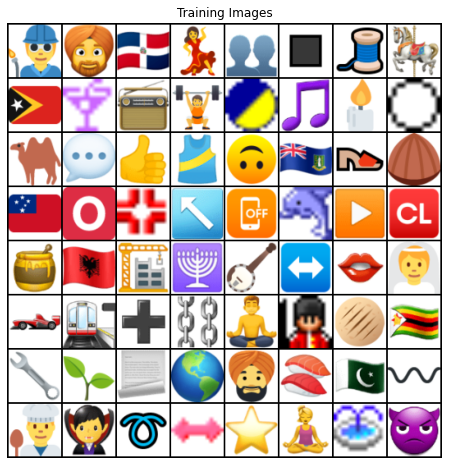

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size,
    shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [5]:
# custom weights initialization called on `net_g` and `net_d`
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. `(ngf*8) x 4 x 4`
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. `(ngf*4) x 8 x 8`
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. `(ngf*2) x 16 x 16`
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. `(ngf) x 32 x 32`
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. `(nc) x 64 x 64`
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
net_g = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if device.type == "cuda" and ngpu > 1:
    net_g = nn.DataParallel(net_g, list(range(ngpu)))


# Reload the weights
# net_g.load_state_dict(torch.load("models/gen.pth"))
# net_g.to(device)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is `(nc) x 64 x 64`
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. `(ndf) x 32 x 32`
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. `(ndf*2) x 16 x 16`
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. `(ndf*4) x 8 x 8`
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. `(ndf*8) x 4 x 4`
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
net_d = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if device.type == "cuda" and ngpu > 1:
    net_d = nn.DataParallel(net_d, list(range(ngpu)))

# Apply the `weights_init` function to randomly initialize all weights
# like this: `to mean=0, stdev=0.2`.
# net_d.load_state_dict(torch.load("models/discr.pth"))
# net_d.to(device)

In [10]:
# Initialize the `BCELoss` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optim_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))
optim_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
g_loss = []
d_loss = []
iters = 0

In [11]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        net_d.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = net_d(real_cpu).view(-1)
        # Calculate loss on all-real batch
        err_d_rl = criterion(output, label)
        # Calculate gradients for D in backward pass
        err_d_rl.backward()
        d_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = net_g(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = net_d(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        err_d_fk = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_d_fk.backward()
        d_g_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        err_d = err_d_rl + err_d_fk
        # Update D
        optim_d.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_g.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = net_d(fake).view(-1)
        # Calculate G's loss based on this output
        err_g = criterion(output, label)
        # Calculate gradients for G
        err_g.backward()
        d_g_z2 = output.mean().item()
        # Update G
        optim_g.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err_d.item(), err_g.item(), d_x, d_g_z1, d_g_z2))

        # Save Losses for plotting later
        g_loss.append(err_g.item())
        d_loss.append(err_d.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if iters % 500 == 0 or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        if iters % 200 == 0 or (epoch == num_epochs - 1)and i == len(dataloader) - 1):
            torch.save(net_g.state_dict(), "models/gen.pth")
            torch.save(net_d.state_dict(), "models/discr.pth")
            print("Weights saved.")
        iters += 1

Starting Training Loop...
[0/150][0/56]	Loss_D: 1.3999	Loss_G: 2.9767	D(x): 0.5133	D(G(z)): 0.5068 / 0.0540
Weights saved.
[0/150][50/56]	Loss_D: 0.2070	Loss_G: 11.6499	D(x): 0.8430	D(G(z)): 0.0000 / 0.0000
[1/150][0/56]	Loss_D: 0.0500	Loss_G: 9.3815	D(x): 0.9604	D(G(z)): 0.0002 / 0.0003
[1/150][50/56]	Loss_D: 0.1708	Loss_G: 4.7887	D(x): 0.9327	D(G(z)): 0.0882 / 0.0096
[2/150][0/56]	Loss_D: 0.2413	Loss_G: 4.3904	D(x): 0.8995	D(G(z)): 0.1139 / 0.0136
[2/150][50/56]	Loss_D: 0.1175	Loss_G: 3.9590	D(x): 0.9324	D(G(z)): 0.0432 / 0.0213
[3/150][0/56]	Loss_D: 0.1732	Loss_G: 6.0985	D(x): 0.9705	D(G(z)): 0.1298 / 0.0026
Weights saved.
[3/150][50/56]	Loss_D: 0.3480	Loss_G: 2.9489	D(x): 0.8805	D(G(z)): 0.1882 / 0.0595
[4/150][0/56]	Loss_D: 1.6307	Loss_G: 7.0058	D(x): 0.9823	D(G(z)): 0.7717 / 0.0011
[4/150][50/56]	Loss_D: 0.2861	Loss_G: 4.4587	D(x): 0.9208	D(G(z)): 0.1764 / 0.0134
[5/150][0/56]	Loss_D: 0.5149	Loss_G: 2.5608	D(x): 0.9856	D(G(z)): 0.3762 / 0.0909
[5/150][50/56]	Loss_D: 1.0031	Loss_G

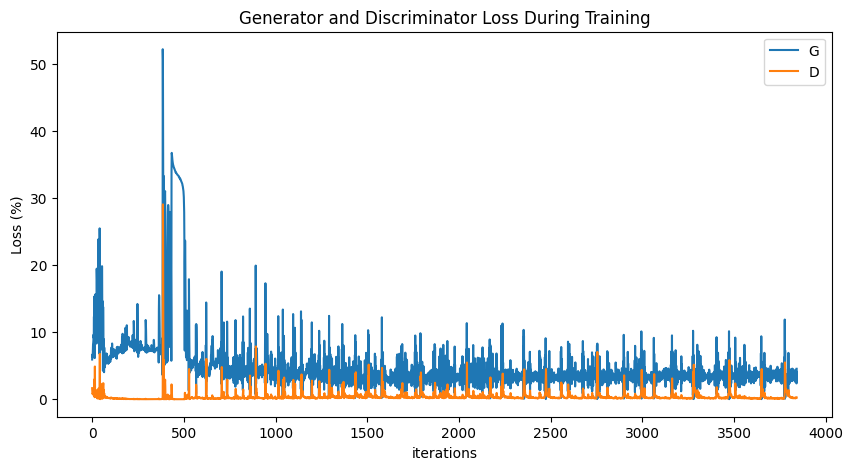

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


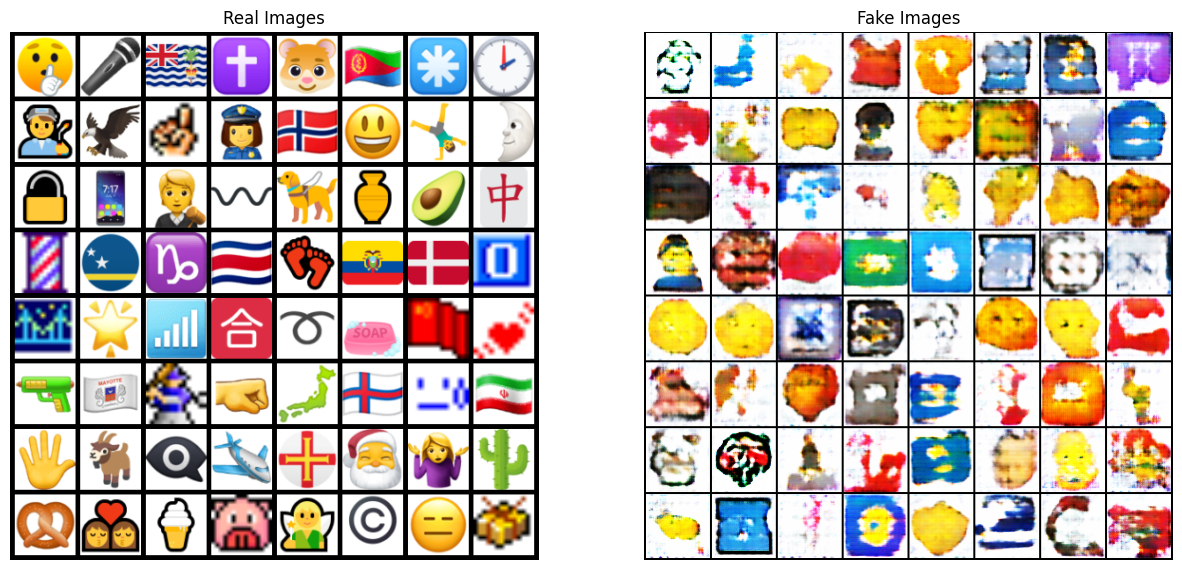

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())